In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, explained_variance_score, mean_squared_log_error

In [3]:
df = pd.read_csv('Steel_industry_data.csv')
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df = df.drop('date', axis=1)
df = pd.get_dummies(df, columns=['WeekStatus', 'Day_of_week', 'Load_Type'], drop_first=True)

In [4]:
# Split the data into features and target variable
X = df.drop('Usage_kWh', axis=1)  # features
y = df['Usage_kWh']  # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor(random_state=42)

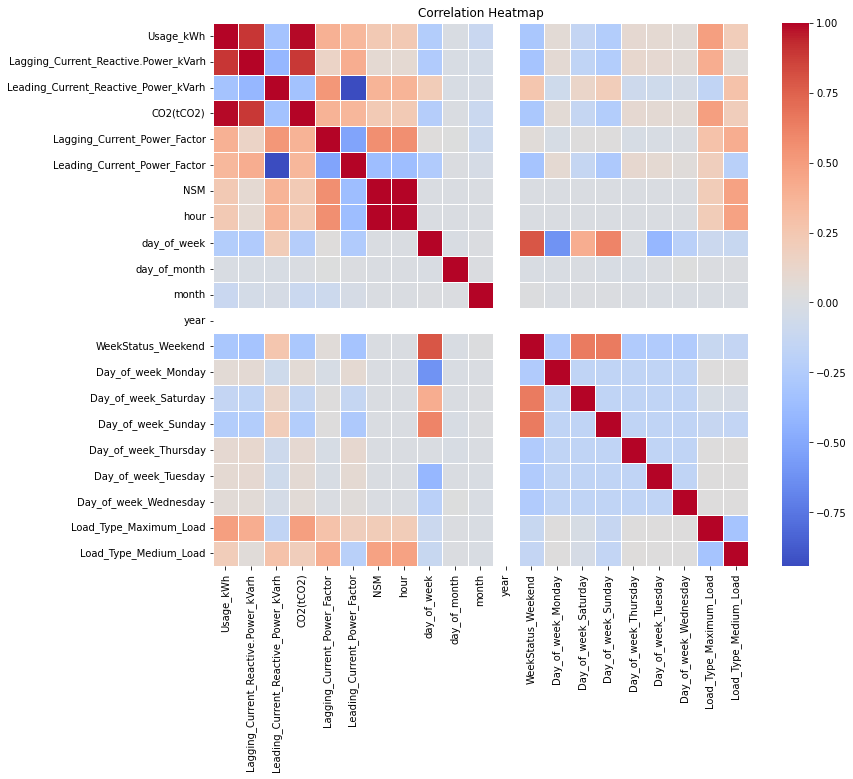

In [5]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

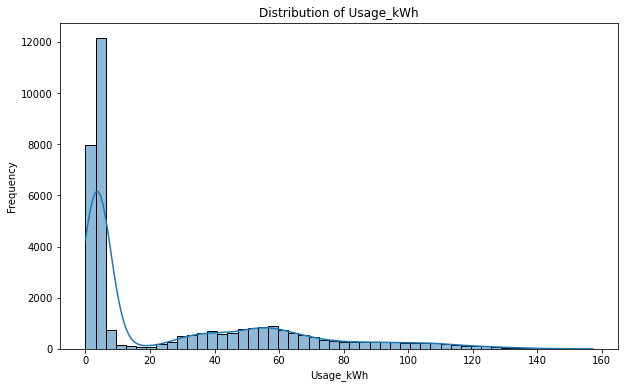

In [6]:
rf_regressor.fit(X_train, y_train)
plt.figure(figsize=(10, 6))
sns.histplot(df['Usage_kWh'], bins=50, kde=True)
plt.title('Distribution of Usage_kWh')
plt.xlabel('Usage_kWh')
plt.ylabel('Frequency')
plt.show()



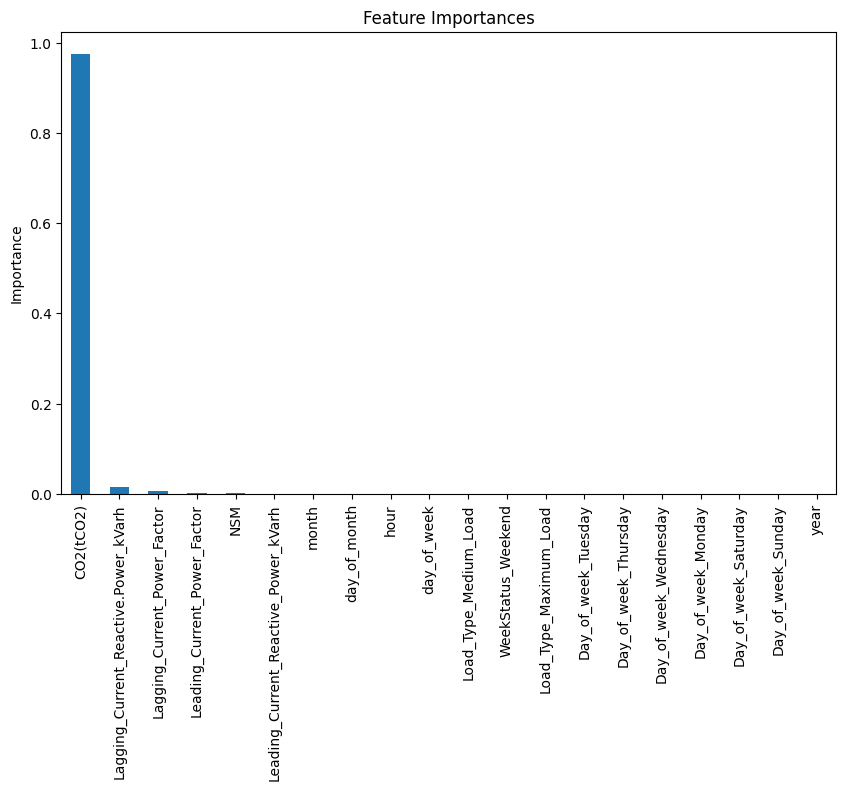

In [56]:
# Feature importance from the Random Forest model
feature_importances = pd.Series(rf_regressor.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.show()


In [57]:
# Feature selection based on importance scores (new code)
threshold = 0.01  # Example threshold
selected_features = feature_importances[feature_importances > threshold].index
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Initialize RFE with Random Forest (new code)
rf_regressor_for_rfe = RandomForestRegressor(random_state=42)
selector = RFECV(estimator=rf_regressor_for_rfe, step=1, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
selector = selector.fit(X_train_selected, y_train)

# Select features based on RFE (new code)
X_train_rfe = selector.transform(X_train_selected)
X_test_rfe = selector.transform(X_test_selected)

In [58]:
# Define the parameter distribution for random search
param_dist = {
    'n_estimators': np.arange(50, 301, 50),
    'max_depth': [None] + list(np.arange(5, 26, 5)),
    'min_samples_split': np.arange(2, 11, 2),
    'min_samples_leaf': np.arange(1, 6),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf_regressor,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    scoring='neg_mean_absolute_error'
)

In [60]:
# Perform the random search on a subset of the training data for faster computation
X_train_subset_rfe, _, y_train_subset, _ = train_test_split(X_train_rfe, y_train, test_size=0.9, random_state=42)
random_search.fit(X_train_subset_rfe, y_train_subset)

# Get the best parameters and the corresponding best score from the random search
best_params_random_subset = random_search.best_params_
best_score_random_subset = -random_search.best_score_  # Negate to get the positive MAE value

# Re-train the model on the full training set using the optimized hyperparameters
optimized_rf_regressor = RandomForestRegressor(
    n_estimators=best_params_random_subset['n_estimators'],
    max_depth=best_params_random_subset['max_depth'],
    min_samples_split=best_params_random_subset['min_samples_split'],
    min_samples_leaf=best_params_random_subset['min_samples_leaf'],
    max_features=best_params_random_subset['max_features'],
    random_state=42
)


optimized_rf_regressor.fit(X_train_rfe, y_train)

y_pred_optimized = optimized_rf_regressor.predict(X_test_rfe)
best_params_random_subset,best_score_random_subset

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


({'n_estimators': 250,
  'min_samples_split': 6,
  'min_samples_leaf': 1,
  'max_features': 'auto',
  'max_depth': 5},
 2.387025539002306)

In [61]:
# Perform cross-validation
cv_scores = cross_val_score(optimized_rf_regressor, X_train_rfe, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_scores = -cv_scores  # Negate to get the positive MAE values
cv_scores_mean = np.mean(cv_scores)
cv_scores_std = np.std(cv_scores)
print(cv_scores,cv_scores_mean,cv_scores_std)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

[2.40984881 2.43579767 2.40256374 2.36206164 2.49927987] 2.421910348898798 0.04534432684504107


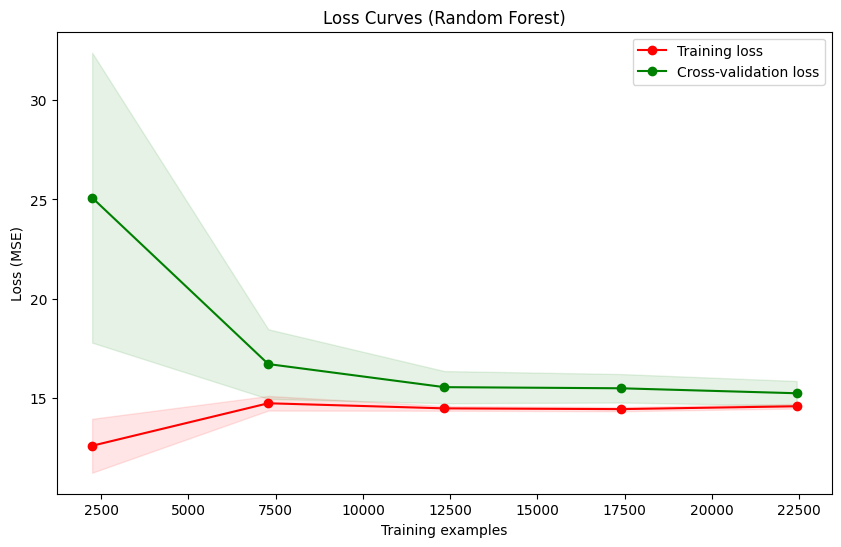

In [62]:
from sklearn.model_selection import learning_curve

# This function plots the learning curve, which is similar to a loss curve,
# but showing the score (negative MSE) instead of the error (MSE)
def plot_loss_curve(estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="neg_mean_squared_error")

    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training loss")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation loss")

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.title("Loss Curves (Random Forest)")
    plt.xlabel("Training examples")
    plt.ylabel("Loss (MSE)")
    plt.legend(loc="best")
    plt.show()

# Call the function with the trained model and training data
# plot_loss_curve(optimized_rf_regressor, X_train, y_train)
plot_loss_curve(optimized_rf_regressor, X_train_rfe, y_train)

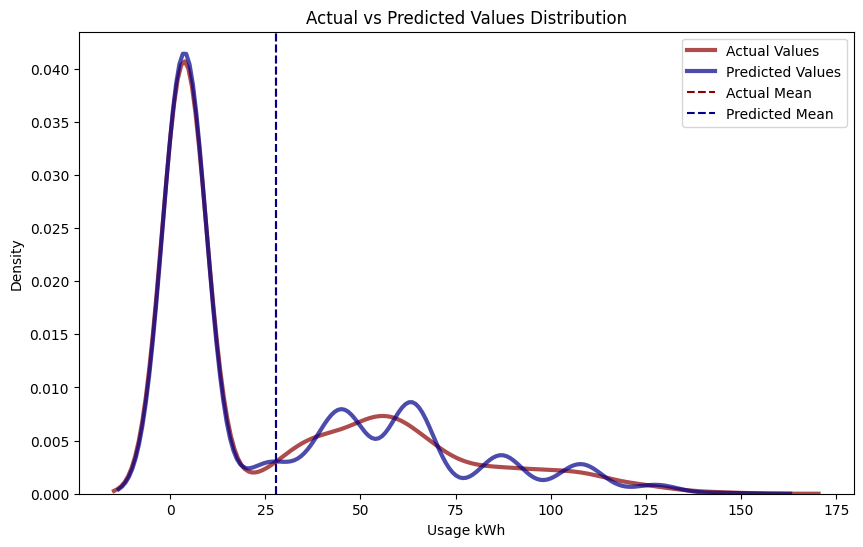

In [63]:
plt.figure(figsize=(10, 6))

# Plot the KDE for actual values
sns.kdeplot(y_test, color='darkred', label='Actual Values', alpha=0.7, lw=3)

# Plot the KDE for predicted values
sns.kdeplot(y_pred_optimized, color='darkblue', label='Predicted Values', alpha=0.7, lw=3)

# Add vertical lines for the mean of the actual and predicted values
plt.axvline(y_test.mean(), color='darkred', linestyle='--', label='Actual Mean')
plt.axvline(y_pred_optimized.mean(), color='darkblue', linestyle='--', label='Predicted Mean')

plt.title('Actual vs Predicted Values Distribution')
plt.xlabel('Usage kWh')
plt.ylabel('Density')
plt.legend()
plt.show()


In [64]:
from sklearn.metrics import (mean_squared_error, mean_absolute_error, median_absolute_error,
                             r2_score, explained_variance_score, mean_squared_log_error)
import numpy as np

# Ensure y_pred_optimized and y_test are defined and contain the predicted and actual values, respectively.

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred_optimized)
print(f"Mean Squared Error (MSE): {mse}")

# Root Mean Squared Error
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred_optimized)
print(f"Mean Absolute Error (MAE): {mae}")

# Median Absolute Error
median_ae = median_absolute_error(y_test, y_pred_optimized)
print(f"Median Absolute Error: {median_ae}")

# R-squared
r2 = r2_score(y_test, y_pred_optimized)
print(f"R-squared (R2): {r2}")

# Adjusted R-squared
n = len(y_test)  # Number of observations
p = X_test.shape[1]  # Number of features (predictors)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f"Adjusted R-squared: {adjusted_r2}")

# Explained Variance Score
explained_variance = explained_variance_score(y_test, y_pred_optimized)
print(f"Explained Variance Score: {explained_variance}")

# Mean Squared Logarithmic Error
msle = mean_squared_log_error(y_test, y_pred_optimized)
print(f"Mean Squared Logarithmic Error (MSLE): {msle}")

# Root Mean Squared Logarithmic Error
rmsle = np.sqrt(msle)
print(f"Root Mean Squared Logarithmic Error (RMSLE): {rmsle}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred_optimized) / y_test)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Squared Error (MSE): 14.577331194919282
Root Mean Squared Error (RMSE): 3.818027133863677
Mean Absolute Error (MAE): 2.3982371824496793
Median Absolute Error: 0.9682750067344217
R-squared (R2): 0.9871759965383315
Adjusted R-squared: 0.9871392883561027
Explained Variance Score: 0.9871775693670374
Mean Squared Logarithmic Error (MSLE): 0.03098705261057109
Root Mean Squared Logarithmic Error (RMSLE): 0.17603139666142256
Mean Absolute Percentage Error (MAPE): 15.767329436895782%


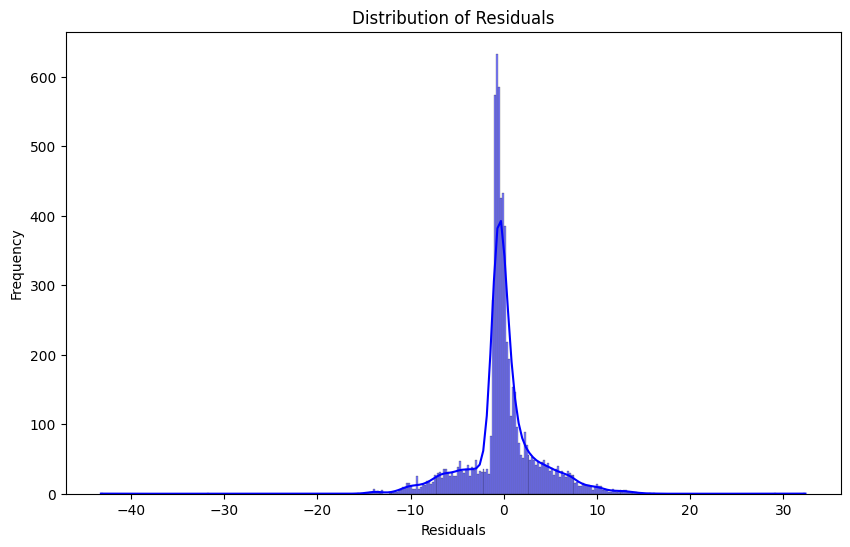

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming error metrics have been calculated and are stored in respective variables

# Visualize the distribution of errors (residuals)
residuals = y_test - y_pred_optimized
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()





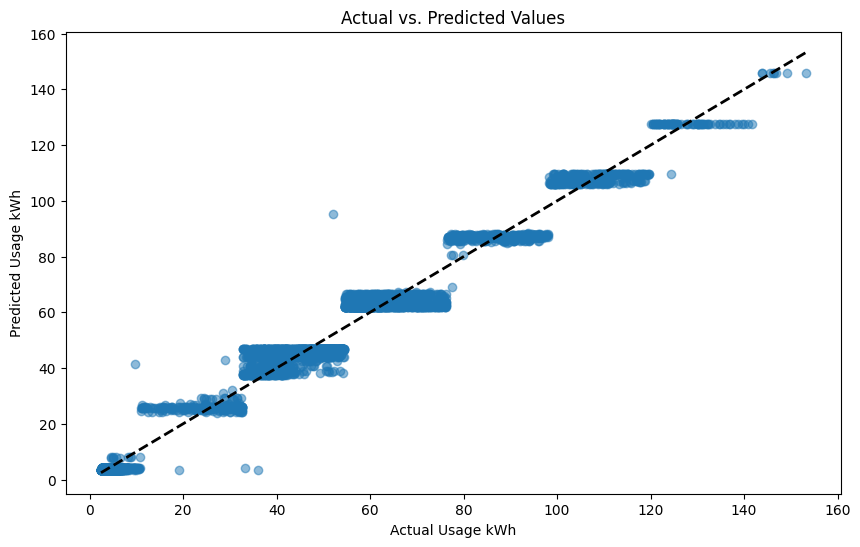

In [66]:
# Scatter plot of Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_optimized, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Usage kWh')
plt.ylabel('Predicted Usage kWh')
plt.show()

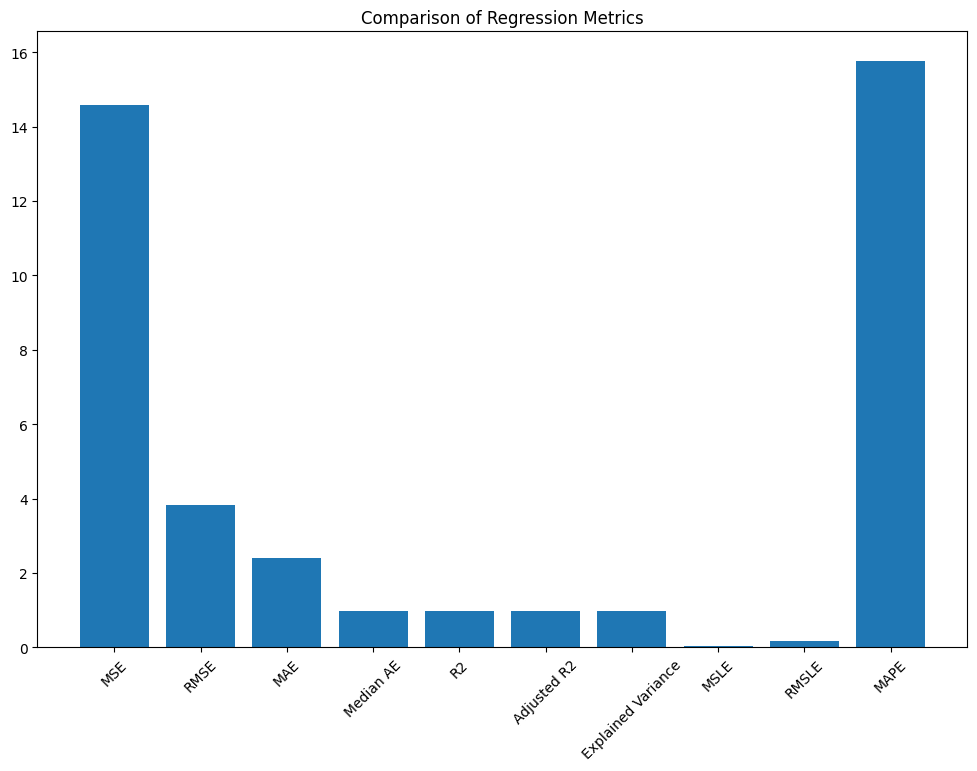

In [67]:
# Bar plot for scalar metrics
scalar_metrics = {
    'MSE': mse,
    'RMSE': rmse,
    'MAE': mae,
    'Median AE': median_ae,
    'R2': r2,
    'Adjusted R2': adjusted_r2,
    'Explained Variance': explained_variance,
    'MSLE': msle,
    'RMSLE': rmsle,
    'MAPE': mape
}

plt.figure(figsize=(12, 8))
plt.bar(range(len(scalar_metrics)), list(scalar_metrics.values()), align='center')
plt.xticks(range(len(scalar_metrics)), list(scalar_metrics.keys()), rotation=45)
plt.title('Comparison of Regression Metrics')
plt.show()
